In [3]:
!pip install scikit-fuzzy


<Figure size 1000x400 with 0 Axes>

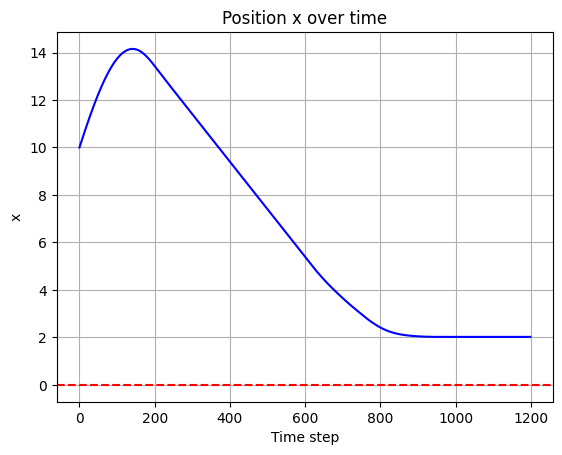

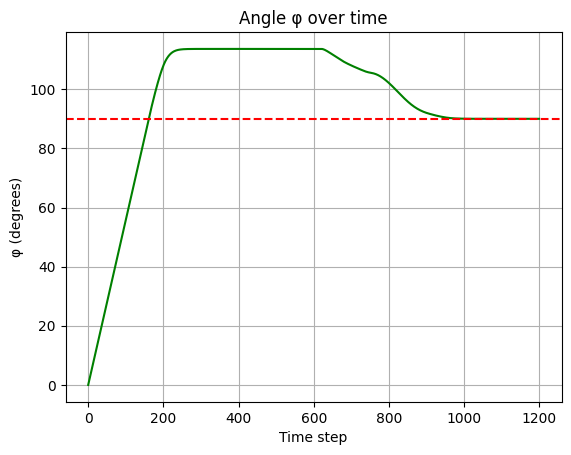

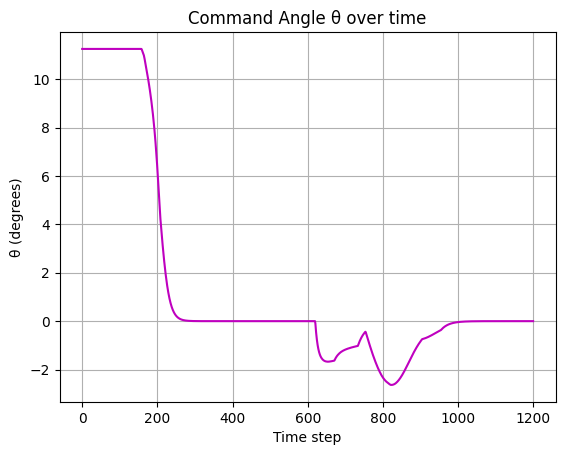

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from skfuzzy import control as ctrl
import skfuzzy as fuzz

# Initial and final states
x0 = 10
y0 = 0
phi0 = 0  # Initial angle relative to the x-axis (0 means aligned with x-axis)
xf = 0
yf = 0
phif = np.pi / 2  # Final angle is 90 degrees (aligned with y-axis)

# Simulation settings
dt = 0.05  # Time step
steps = 1200  # Number of steps
b = 2  # Parameter for the angle update equation

# Define variables for position and angle
x = np.zeros(steps)
y = np.zeros(steps)
phi = np.zeros(steps)
theta = np.zeros(steps)

# Initial values
x[0] = x0
y[0] = y0
phi[0] = phi0

# Define fuzzy system
distance = ctrl.Antecedent(np.linspace(-15, 15, 100), 'Distance')
delta_phi = ctrl.Antecedent(np.linspace(-np.pi, np.pi, 100), 'DeltaPhi')
theta_output = ctrl.Consequent(np.linspace(-np.pi / 8, np.pi / 8, 100), 'Theta')

# Membership functions for 'Distance'
distance['FarLeft'] = fuzz.trapmf(distance.universe, [-15, -15, -5, -2])
distance['Center'] = fuzz.trimf(distance.universe, [-5, 0, 5])
distance['FarRight'] = fuzz.trapmf(distance.universe, [2, 5, 15, 15])

# Membership functions for 'DeltaPhi'
delta_phi['Left'] = fuzz.trapmf(delta_phi.universe, [-np.pi, -np.pi, -np.pi / 4, 0])
delta_phi['Center'] = fuzz.trimf(delta_phi.universe, [-np.pi / 8, 0, np.pi / 8])
delta_phi['Right'] = fuzz.trapmf(delta_phi.universe, [0, np.pi / 4, np.pi, np.pi])

# Membership functions for 'Theta'
theta_output['Left'] = fuzz.trimf(theta_output.universe, [-np.pi / 8, -np.pi / 16, 0])
theta_output['Straight'] = fuzz.trimf(theta_output.universe, [-np.pi / 32, 0, np.pi / 32])
theta_output['Right'] = fuzz.trimf(theta_output.universe, [0, np.pi / 16, np.pi / 8])

# Rules for fuzzy control
rule1 = ctrl.Rule(distance['FarLeft'] & delta_phi['Left'], theta_output['Left'])
rule2 = ctrl.Rule(distance['FarLeft'] & delta_phi['Center'], theta_output['Left'])
rule3 = ctrl.Rule(distance['FarLeft'] & delta_phi['Right'], theta_output['Straight'])
rule4 = ctrl.Rule(distance['Center'] & delta_phi['Left'], theta_output['Left'])
rule5 = ctrl.Rule(distance['Center'] & delta_phi['Center'], theta_output['Straight'])
rule6 = ctrl.Rule(distance['Center'] & delta_phi['Right'], theta_output['Right'])
rule7 = ctrl.Rule(distance['FarRight'] & delta_phi['Left'], theta_output['Straight'])
rule8 = ctrl.Rule(distance['FarRight'] & delta_phi['Center'], theta_output['Right'])
rule9 = ctrl.Rule(distance['FarRight'] & delta_phi['Right'], theta_output['Right'])

# Control system
parking_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9])
parking = ctrl.ControlSystemSimulation(parking_ctrl)

# Simulate the system (movement in reverse for parking)
for k in range(steps - 1):  # Ensure no index out of range error
    # Distance and delta_phi for the fuzzy controller
    distance_value = x[k] - xf
    delta_phi_value = phif - phi[k]

    # Fuzzy control
    parking.input['Distance'] = distance_value
    parking.input['DeltaPhi'] = delta_phi_value
    parking.compute()

    # Ensure that 'Theta' exists in parking.output
    if 'Theta' in parking.output:
        theta[k] = parking.output['Theta']
        # Limit theta to the range [-pi/8, pi/8]
        theta[k] = np.sign(theta[k]) * min(abs(theta[k]), np.pi / 8)

    else:
        print("Error: 'Theta' output not found")
        break

    # Update the state using the model equations (reverse movement)
    x[k + 1] = x[k] + np.cos(phi[k] + theta[k]) * dt
    y[k + 1] = y[k] + np.sin(phi[k] + theta[k]) * dt
    phi[k + 1] = phi[k] + (2 * np.sin(theta[k]) / b) * dt  # Angle update for reverse movement


    # Stop if the goal is reached (close enough to the target position and angle)
    # Stop if both conditions are met (close to target position and angle)
    if abs(x[k + 1] - xf) < 0.01 and abs(phi[k + 1] - phif) < 0.01:
        print(f"Reached goal at step {k}")
        x = x[:k + 1]
        y = y[:k + 1]
        phi = phi[:k + 1]
        theta = theta[:k]
        break


# Plot the results
fig = plt.figure(figsize=(10, 4))

# Plot for x position
plt.figure()
plt.plot(range(len(x)), x, 'b', linewidth=1.5)
plt.axhline(0, color='r', linestyle='--', linewidth=1.5)
plt.grid(True)
plt.title('Position x over time')
plt.xlabel('Time step')
plt.ylabel('x')

# Plot for phi (angle)
plt.figure()
plt.plot(range(len(phi)), phi * 180 / np.pi, 'g', linewidth=1.5)
plt.axhline(90, color='r', linestyle='--', linewidth=1.5)
plt.grid(True)
plt.title('Angle φ over time')
plt.xlabel('Time step')
plt.ylabel('φ (degrees)')

# Plot for theta (steering angle)
plt.figure()
plt.plot(range(len(theta)), theta * 180 / np.pi, 'm', linewidth=1.5)  # theta in degrees
plt.grid(True)
plt.title('Command Angle θ over time')
plt.xlabel('Time step')
plt.ylabel('θ (degrees)')

plt.show()
